In [1]:
#import warnings
#warnings.filterwarnings('ignore')

import datacube

import matplotlib.pyplot as plt
import matplotlib.cm as color_maps  
from matplotlib.pyplot import figure, cm

import json
import time
import sys
import os

import rasterio
import rasterio.mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.merge import merge
from rasterio.plot import show

import rioxarray as rio

import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
from osgeo import ogr, gdal

from datetime import datetime
#from time import time

import skimage
from skimage import exposure
from skimage import morphology
from skimage.morphology import disk
from skimage.morphology import rectangle
from skimage.filters import rank

import glob
import fiona
import subprocess

import utils.data_cube_utilities.dc_utilities as utils
from utils.data_cube_utilities.data_access_api import DataAccessApi
from utils.data_cube_utilities.dc_utilities import write_geotiff_from_xr, write_png_from_xr
from utils.data_cube_utilities.dc_chunker import create_geographic_chunks, combine_geographic_chunks
from utils.data_cube_utilities.dc_mosaic import create_median_mosaic, create_mosaic
from utils.data_cube_utilities.dc_sar_utils import dn_to_db 

from rmmeh.vanilla import rmmeh

In [2]:
def rasterization(InputVector,OutputImage,RefImage):
    gdalformat = 'GTiff'
    datatype = gdal.GDT_Byte
    burnVal = 1 #value for the output image pixels
    ##########################################################
    # Get projection info from reference image
    Image = gdal.Open(RefImage, gdal.GA_ReadOnly)
    print(Image)

    # Open Shapefile
    Shapefile = ogr.Open(InputVector)
    Shapefile_layer = Shapefile.GetLayer()

    # Rasterising
    print("Rasterising shapefile...")
    Output = gdal.GetDriverByName(gdalformat).Create(OutputImage, Image.RasterXSize, Image.RasterYSize, 1, datatype, options=['COMPRESS=DEFLATE'])
    Output.SetProjection(Image.GetProjectionRef())
    Output.SetGeoTransform(Image.GetGeoTransform()) 

    # Write data to band 1
    Band = Output.GetRasterBand(1)
    Band.SetNoDataValue(0)
    gdal.RasterizeLayer(Output, [1], Shapefile_layer, burn_values=[burnVal])

    # Close datasets
    Band = None
    Output = None
    Image = None
    Shapefile = None

    # Build image overviews
    subprocess.call("gdaladdo --config COMPRESS_OVERVIEW DEFLATE "+OutputImage+" 2 4 8 16 32 64", shell=True)


    print("Done.")

    print('finist_rasterise_vector')
    
def rgb(dataset, bands = ['nir', 'red', 'green'], paint_on_mask = []):
    
    fig=plt.figure()
    fig.set_size_inches(9, 9)
    
    rgb = np.stack([dataset[bands[0]], dataset[bands[1]], dataset[bands[2]]], axis = -1)
    rgb = rgb.astype(np.float32)

    p2, p98 = np.percentile(rgb, (2, 98))
    rgb = exposure.rescale_intensity(rgb, in_range=(p2, p98)) * 255.0

    rgb = rgb.astype(int) 

    for mask, color in paint_on_mask:        
        rgb[mask] = np.array([256,256,256]) - np.array(color).astype(np.int16)
    plt.imshow(rgb)
        
def generate_cloud_mask(dataset, include_shadows = False):
    #Create boolean Masks for clear and water pixels
      
    clear_pixels = dataset.pixel_qa.values == (2 ) 
    water_pixels = dataset.pixel_qa.values == (4 )
    shadow_pixels= dataset.pixel_qa.values == (3 )
           
    #a_clean_mask = np.logical_or(clear_pixels, water_pixels)
    a_clean_mask = np.logical_or(1, 1)
    if include_shadows:
        a_clean_mask = np.logical_or(a_clean_mask, shadow_pixels)
        
    return np.invert(a_clean_mask)

def mrf_mosaic(dataset):
    # The mask here is based on pixel_qa products. It comes bundled in with most Landsat Products.
    cloud_free_boolean_mask = np.invert(generate_cloud_mask(dataset))
    #cloud_free_boolean_mask = generate_cloud_mask(dataset)
    return create_mosaic(dataset, clean_mask = cloud_free_boolean_mask)

In [3]:
sugarcane_shp = './shp/clipped_sugarcane.shp'
rice_shp = './shp/clipped_rice.shp'
RefImage = './refImage4.tif'

InputVector = sugarcane_shp
OutputImage = 'clipped_sugarcane4.tif'
rasterization(InputVector,OutputImage,RefImage)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f58ec0976f0> >
Rasterising shapefile...
Done.
finist_rasterise_vector


In [4]:
InputVector = rice_shp
OutputImage = 'clipped_rice4.tif'
rasterization(InputVector,OutputImage,RefImage)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f586e447900> >
Rasterising shapefile...
Done.
finist_rasterise_vector


In [5]:
real_sugar = rasterio.open('clipped_sugarcane4.tif')
real_rice = rasterio.open('clipped_rice4.tif')
print(real_sugar.height, real_sugar.width)

sugar_pix = real_sugar.read(1)
rice_pix = real_rice.read(1)


303 379


In [6]:
import matplotlib.pyplot as plt
import matplotlib.cm as color_maps 

three_classes = sugar_pix.copy()

w=real_sugar.width
h=real_sugar.height

for i in range(w):
    for j in range(h):
        if rice_pix[j][i] == 1:
            three_classes[j][i] = 2


Text(0.5, 1.0, 'Detected area')

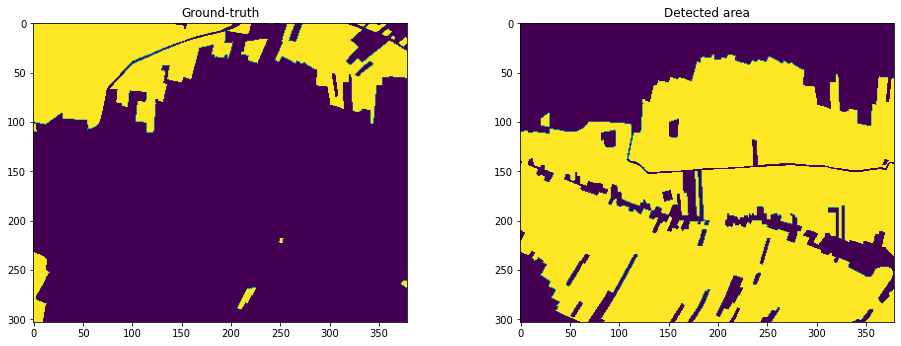

In [7]:
fig=plt.figure()
fig.set_size_inches(16, 5.5)
fig.add_subplot(1, 2, 1)
plt.imshow(sugar_pix)
plt.title("Ground-truth")

fig.add_subplot(1, 2, 2)
plt.imshow(rice_pix)
plt.title("Detected area")

Text(0.5, 1.0, 'Detected area')

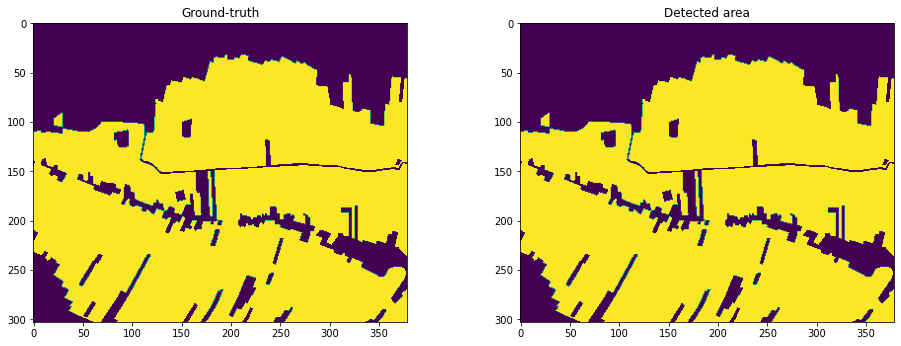

In [8]:
fig=plt.figure()
fig.set_size_inches(16, 5.5)
fig.add_subplot(1, 2, 1)
plt.imshow(rice_pix)
plt.title("Ground-truth")

fig.add_subplot(1, 2, 2)
plt.imshow(rice_pix)
plt.title("Detected area")

Text(0.5, 1.0, 'Detected area')

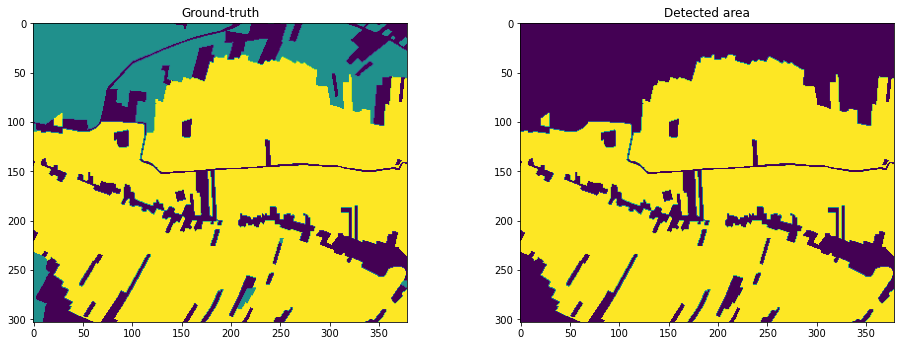

In [9]:
fig=plt.figure()
fig.set_size_inches(16, 5.5)
fig.add_subplot(1, 2, 1)
plt.imshow(three_classes)
plt.title("Ground-truth")

fig.add_subplot(1, 2, 2)
plt.imshow(rice_pix)
plt.title("Detected area")